In [110]:
# Some basic imports and setup
import numpy as np, numpy.random as nr, gym
import matplotlib.pyplot as plt
import time
np.set_printoptions(precision=3)
from robolearn.envs.frozen_lake import FrozenLakeEnv


In [14]:
class MDP(object):
    """
    mdp.P is a two-level dict where the first key is the state and the second key is the action.
    The 2D grid cells are associated with indices [0, 1, 2, ..., 15] from left to right and top to down, as in
     [[ 0  1  2  3]
      [ 4  5  6  7]
      [ 8  9 10 11]
      [12 13 14 15]]
    Action indices [0, 1, 2, 3] correspond to West, South, East and North.
    mdp.P[state][action] is a list of tuples (probability, nextstate, reward).
    For example, state 0 is the initial state, and the transition information for s=0, a=0 is P[0][0] = [(1.0, 0, 0.0)]",
    As another example, state 5 corresponds to a hole in the ice, in which all actions lead to the same 
    state with probability 1 and reward 0:
    P[5][0] = [(1.0, 5, 0.0)]
    P[5][1] = [(1.0, 5, 0.0)]
    P[5][2] = [(1.0, 5, 0.0)]
    P[5][3] = [(1.0, 5, 0.0)]
    """
    def __init__(self, P, nS, nA, desc=None):
        self.P = P # state transition and reward probabilities, explained below
        self.nS = nS # number of states
        self.nA = nA # number of actions
        self.desc = desc # 2D array specifying what each grid cell means (used for plotting)

In [74]:
def value_iteration(mdp, gamma, nIt, show_log=False):
    """
    Inputs:
        mdp: MDP
        gamma: discount factor
        nIt: number of iterations, corresponding to n above
    Outputs:
        (value_functions, policies)

    len(value_functions) == nIt+1 and len(policies) == nIt
    """
    if show_log:
        print("Iteration | max|V-Vprev| | # chg actions | V[0]")
        print("----------+--------------+---------------+---------")
    Vs = [np.zeros(mdp.nS)] # list of value functions contains the initial value function V^{(0)}, which is zero
    pis = []
    for it in range(nIt):
        oldpi = pis[-1] if len(pis) > 0 else None # \pi^{(it)} = Greedy[V^{(it-1)}]. Just used for printout
        Vprev = Vs[-1] # V^{(it)}

        # Your code should fill in meaningful values for the following two variables
        # pi: greedy policy for Vprev (not V), 
        #     corresponding to the math above: \pi^{(it)} = Greedy[V^{(it)}]
        #     ** it needs to be numpy array of ints **
        # V: bellman backup on Vprev
        #     corresponding to the math above: V^{(it+1)} = T[V^{(it)}]
        #     ** numpy array of floats **

#         V = Vprev # REPLACE THIS LINE WITH YOUR CODE
#         pi = oldpi # REPLACE THIS LINE WITH YOUR CODE
        V = np.zeros_like(Vprev)
        pi = np.zeros_like(V)

        for s in range(mdp.nS):
            q = np.zeros(mdp.nA)
            for a in range(mdp.nA):
                for s_prime_prob, s_prime, reward in mdp.P[s][a]:
                    q[a] += s_prime_prob*(reward + gamma * Vprev[s_prime])
            V[s] = np.max(q)
            pi[s] = np.argmax(q)

        if show_log:
            max_diff = np.abs(V - Vprev).max()
            nChgActions="N/A" if oldpi is None else (pi != oldpi).sum()
            print("%4i      | %6.5f      | %4s          | %5.3f"%(it, max_diff, nChgActions, V[0]))
            
        Vs.append(V)
        pis.append(pi)
    return Vs, pis

In [75]:
def plot_value_iteration(Vs, pis, iters_to_plot=None, ncol=4, nrow=4):
    square_size = .5
    if iters_to_plot is None:
        iters_to_plot = [-1]
    Vs_to_plot = [Vs[iteration] for iteration in iters_to_plot]
    pis_to_plot = [pis[iteration] for iteration in iters_to_plot]
    for pp, (_V, _pi) in enumerate(zip(Vs_to_plot, pis_to_plot)):
        
        plt.figure()#figsize=(3,3))
        plt.imshow(_V.reshape(ncol,nrow), cmap='gray', interpolation='none', clim=(0,1))
        ax = plt.gca()
        ax.set_xticks(np.arange(ncol)-square_size)
        ax.set_yticks(np.arange(nrow)-square_size)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        Y, X = np.mgrid[0:4, 0:4]
        a2uv = {0: (-1, 0), 1:(0, -1), 2:(1,0), 3:(0, 1)}
        Pi = _pi.reshape(ncol,nrow)
        for y in range(ncol):
            for x in range(nrow):
                a = Pi[y, x]
                # Arrow
                u, v = a2uv[a]
                plt.arrow(x, y,u*.3, -v*.3, color='m', head_width=0.1, head_length=0.1) 
                # Text
                plt.text(x, y, str(env.desc[y,x].item().decode()),
                         color='g', size=12,  verticalalignment='center',
                         horizontalalignment='center', fontweight='bold')
                plt.text(x-square_size/3, y-square_size/2, str(np.around(_V[4*y+x], decimals=2)),
                         color='r', size=8,  verticalalignment='center',
                         horizontalalignment='center')
        plt.grid(color='b', lw=2, ls='-')

        print('Iter %d' % pp)
        plt.show()
        print('-'*20)

In [76]:
class Agent(object):

    def __init__(self, policy):
        self.policy = policy
        
    def act(self, state):
        return self.policy[state]
    


In [101]:
GAMMA = 0.95 # we'll be using this same value in subsequent problems
nIt = 300
env = FrozenLakeEnv(map_name='4x4', is_slippery=False, reward_dict={'G':1, 'S':0, 'H':-1, 'F':-0.00})

# Create a MDP from the environment
mdp = MDP( {s : {a : [tup[:3] for tup in tups] for (a, tups) in a2d.items()} for (s, a2d) in env.P.items()}, env.nS, env.nA, env.desc)

# Learn with Value Iteration a policy
Vs_VI, pis_VI = value_iteration(mdp, gamma=GAMMA, nIt=nIt, show_log=False)

Iter 0


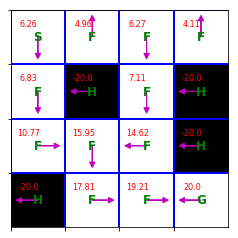

--------------------


In [100]:
# Visualize Policy
%matplotlib inline
iters_to_plot = [-1]  # Plot only last VI values
plot_value_iteration(Vs_VI, pis_VI, iters_to_plot, env.ncol, env.nrow)

<IPython.core.display.Javascript object>


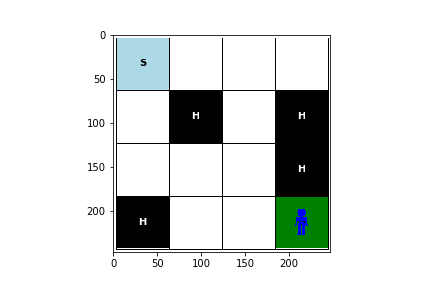

/home/domingo/robotlearning-workspace/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


iter 0 | ob 4 | action 1.0 | reward -0.0
iter 1 | ob 8 | action 1.0 | reward -0.0
iter 2 | ob 9 | action 2.0 | reward -0.0
iter 3 | ob 13 | action 1.0 | reward -0.0
iter 4 | ob 14 | action 2.0 | reward -0.0
iter 5 | ob 15 | action 2.0 | reward 1.0
Finished at t=6 | Acum reward: 1.0


<IPython.core.display.Javascript object>


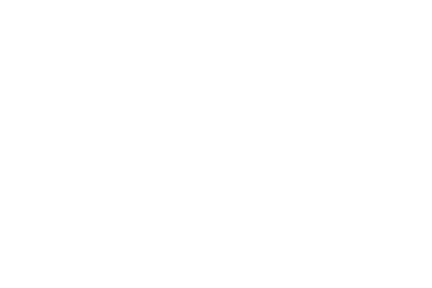

In [109]:
%matplotlib notebook
# Seed RNGs
env.seed(0); from gym.spaces import prng; prng.seed(10)

# Notebook figure
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# Agent from previous VI
agent = Agent(pis_VI[-1])

# Generate the episode
ob = env.reset()
render = ax.imshow(env.render(mode='rgb_array'))
ret = 0
for t in range(50):
    fig.canvas.set_window_title('Frozen Lake -- Iteration: %02d' % t)
    time.sleep(0.5)
    render.set_data(env.render(mode='rgb_array'))
    fig.canvas.draw()
#     a = env.action_space.sample()
    a = agent.act(ob)
    ob, rew, done, _ = env.step(a)
    ret += rew
    print('iter', t, '| ob',ob,'| action',a,'| reward',rew)
    if done:
        break
assert done
fig.canvas.set_window_title('Frozen Lake -- Iteration: %02d' % t)
time.sleep(0.5)
render.set_data(env.render(mode='rgb_array'))
fig.canvas.draw()
# env.render(close=True)
print('Finished at t=%d'%(t+1),'| Acum reward:', ret)